In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import clip

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [98]:
# paths 
DATA_PATH = '../dataset/Hearthstone-Minion-race/'
IMAGE_PATH = '../dataset/Hearthstone-Minion-race/'

In [99]:
df = pd.read_csv(DATA_PATH+"/train.csv")
df_test = pd.read_csv(DATA_PATH+"/test.csv")
df_test.head()

,cardClass,health,id,name,set,attack,cost,rarity,artist,collectible,text,mechanics,race,Image Path
0,ROGUE,3,EX1_191,Plaguebringer,LEGACY,3,4,FREE,J. Axer,1.0,<b>Battlecry:</b> Give a friendly minion <b>Po...,['BATTLECRY'],NONE_race,test_images/EX1_191.jpg
1,PRIEST,3,REV_246,Mysterious Visitor,REVENDRETH,2,2,EPIC,Arthur Bozonnet,1.0,<b>Battlecry:</b> Reduce the Cost of cards cop...,['BATTLECRY'],NONE_race,test_images/REV_246.jpg
2,PRIEST,1,CRED_98,Giovanni Scarpati,CREDITS,3,7,LEGENDARY,NaN,NaN,[x]<b>Divine Shield</b>. <b>Divine Shield</b>....,NaN,NONE_race,test_images/CRED_98.jpg
3,NEUTRAL,3,Prologue_UnstableEnergy3,Fel Unstable Energy,BLACK_TEMPLE,5,3,FREE,NaN,NaN,Can't attack.\n<b>Deathrattle:</b> Deal 2 dama...,"['CANT_ATTACK', 'DEATHRATTLE']",NONE_race,test_images/Prologue_UnstableEnergy3.jpg
4,PALADIN,5,TRLA_138,Shirvallah's Grace,TROLL,0,0,FREE,Danny Dai,NaN,[x]<b>Shrine</b>\nAfter you cast a spell\non a...,"['TRIGGER_VISUAL', 'InvisibleDeathrattle']",NONE_race,test_images/TRLA_138.jpg


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5398 entries, 0 to 5397
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cardClass    4971 non-null   object 
 1   health       5398 non-null   int64  
 2   id           5398 non-null   object 
 3   name         5398 non-null   object 
 4   set          5398 non-null   object 
 5   attack       5398 non-null   int64  
 6   cost         5398 non-null   int64  
 7   rarity       5398 non-null   object 
 8   artist       2999 non-null   object 
 9   collectible  2319 non-null   float64
 10  text         4626 non-null   object 
 11  mechanics    4036 non-null   object 
 12  race         5398 non-null   object 
 13  Image Path   5398 non-null   object 
dtypes: float64(1), int64(3), object(10)
memory usage: 590.5+ KB


In [5]:
df.head()

,cardClass,health,id,name,set,attack,cost,rarity,artist,collectible,text,mechanics,race,Image Path
0,ROGUE,13,Story_06_Tethys,Fleet Admiral Tethys,DARKMOON_FAIRE,1,4,FREE,NaN,NaN,"At the end of your turn, deal 1 damage to all ...",['TRIGGER_VISUAL'],NONE_race,train_images/Story_06_Tethys.jpg
1,NEUTRAL,5,EX1_016,Sylvanas Windrunner,EXPERT1,5,6,LEGENDARY,Glenn Rane,1.0,<b>Deathrattle:</b> Take\ncontrol of a random\...,['DEATHRATTLE'],NONE_race,train_images/EX1_016.jpg
2,NEUTRAL,15,Story_10_IcecrownObelisk,Icecrown Obelisk,STORMWIND,0,3,FREE,NaN,NaN,<b>Deathrattle:</b> Gain control of this minion.,['DEATHRATTLE'],NONE_race,train_images/Story_10_IcecrownObelisk.jpg
3,DRUID,5,CORE_CS3_012,Nordrassil Druid,PLACEHOLDER_202204,3,4,RARE,Dave Greco,1.0,<b>Battlecry:</b> The next spell you cast this...,['BATTLECRY'],NONE_race,train_images/CORE_CS3_012.jpg
4,MAGE,7,BOM_09_Dawngrasp_008t,Dawngrasp,ALTERAC_VALLEY,1,1,FREE,NaN,NaN,<b>Freeze</b> any character damaged by this mi...,['FREEZE'],NONE_race,train_images/BOM_09_Dawngrasp_008t.jpg


In [6]:
df.shape

(5398, 14)

In [7]:
df.isnull().sum()

cardClass       427
health            0
id                0
name              0
set               0
attack            0
cost              0
rarity            0
artist         2399
collectible    3079
text            772
mechanics      1362
race              0
Image Path        0
dtype: int64

In [8]:
df['cardClass'].unique()

array(['ROGUE', 'NEUTRAL', 'DRUID', 'MAGE', 'WARRIOR', 'WARLOCK',
       'PRIEST', 'HUNTER', nan, 'SHAMAN', 'PALADIN', 'DEMONHUNTER',
       'DREAM'], dtype=object)

In [9]:
df['rarity'].unique()

array(['FREE', 'LEGENDARY', 'RARE', 'COMMON', 'EPIC'], dtype=object)

In [10]:
df['race'].unique()

array(['NONE_race', 'BEAST', 'DRAGON', 'DEMON', 'PIRATE', 'TOTEM',
       'MURLOC', 'ELEMENTAL', 'MECHANICAL', 'QUILBOAR', 'ORC', 'TAUREN',
       'NAGA', 'HUMAN', 'OLDGOD'], dtype=object)

In [11]:
df[df['collectible'].isna()]

,cardClass,health,id,name,set,attack,cost,rarity,artist,collectible,text,mechanics,race,Image Path
0,ROGUE,13,Story_06_Tethys,Fleet Admiral Tethys,DARKMOON_FAIRE,1,4,FREE,NaN,NaN,"At the end of your turn, deal 1 damage to all ...",['TRIGGER_VISUAL'],NONE_race,train_images/Story_06_Tethys.jpg
2,NEUTRAL,15,Story_10_IcecrownObelisk,Icecrown Obelisk,STORMWIND,0,3,FREE,NaN,NaN,<b>Deathrattle:</b> Gain control of this minion.,['DEATHRATTLE'],NONE_race,train_images/Story_10_IcecrownObelisk.jpg
4,MAGE,7,BOM_09_Dawngrasp_008t,Dawngrasp,ALTERAC_VALLEY,1,1,FREE,NaN,NaN,<b>Freeze</b> any character damaged by this mi...,['FREEZE'],NONE_race,train_images/BOM_09_Dawngrasp_008t.jpg
6,MAGE,3,Prologue_Sorcerer,Highborne Sorcerer,BLACK_TEMPLE,5,6,COMMON,NaN,NaN,<b>Spell Damage +2</b>\n<b>Battlecry:</b> Draw...,"['BATTLECRY', 'SPELLPOWER']",NONE_race,train_images/Prologue_Sorcerer.jpg
7,NEUTRAL,15,Story_05_SamtheWise,Sam the Wise,DARKMOON_FAIRE,3,1,FREE,NaN,NaN,"[x]At the start of your turn,\nrestore 3 Healt...","['DEATHRATTLE', 'TRIGGER_VISUAL']",NONE_race,train_images/Story_05_SamtheWise.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5393,NEUTRAL,9,LT24_001E1m_02,Tentacle of C'Thun 2,LETTUCE,3,5,FREE,NaN,NaN,"<b>Taunt</b>.\nAfter this <b>Attacks</b>, give...",['TRIGGER_VISUAL'],OLDGOD,train_images/LT24_001E1m_02.jpg
5394,NaN,74,LT23_025H_03,N'Zoth,LETTUCE,10,4,LEGENDARY,NaN,NaN,NaN,NaN,OLDGOD,train_images/LT23_025H_03.jpg
5395,NEUTRAL,13,LT24_001H_01,C'Thun,LETTUCE,3,0,LEGENDARY,NaN,NaN,NaN,NaN,OLDGOD,train_images/LT24_001H_01.jpg
5396,NEUTRAL,100,LT23_816H4,Embodied Despair,LETTUCE,15,0,EPIC,NaN,NaN,<b>Taunt</b>,NaN,OLDGOD,train_images/LT23_816H4.jpg


In [12]:
df[df['text'].isna()]

,cardClass,health,id,name,set,attack,cost,rarity,artist,collectible,text,mechanics,race,Image Path
13,NEUTRAL,1,BRM_004t,Whelp,BRM,1,1,FREE,NaN,NaN,NaN,NaN,NONE_race,train_images/BRM_004t.jpg
33,NEUTRAL,3,CFM_712_t03,Jade Golem,GANGS,3,3,FREE,Konstantin Turovec,NaN,NaN,NaN,NONE_race,train_images/CFM_712_t03.jpg
38,NEUTRAL,1,TU4a_002,Riverpaw Gnoll,MISSIONS,2,1,COMMON,NaN,NaN,NaN,NaN,NONE_race,train_images/TU4a_002.jpg
43,NaN,10,BARL_001H_03,Serena Bloodfeather,LETTUCE,2,4,RARE,NaN,NaN,NaN,NaN,NONE_race,train_images/BARL_001H_03.jpg
56,NEUTRAL,0,LETL_916_01,Boon: Protectors,LETTUCE,0,0,FREE,NaN,NaN,NaN,NaN,NONE_race,train_images/LETL_916_01.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5386,NaN,43,LT23_026H_02,Yogg-Saron,LETTUCE,6,4,LEGENDARY,NaN,NaN,NaN,NaN,OLDGOD,train_images/LT23_026H_02.jpg
5390,NaN,80,LT23_026H_03,Yogg-Saron,LETTUCE,10,4,LEGENDARY,NaN,NaN,NaN,NaN,OLDGOD,train_images/LT23_026H_03.jpg
5391,NaN,12,LT23_028H_01,Y'Shaarj,LETTUCE,2,4,LEGENDARY,NaN,NaN,NaN,NaN,OLDGOD,train_images/LT23_028H_01.jpg
5394,NaN,74,LT23_025H_03,N'Zoth,LETTUCE,10,4,LEGENDARY,NaN,NaN,NaN,NaN,OLDGOD,train_images/LT23_025H_03.jpg


In [13]:
df.head()

,cardClass,health,id,name,set,attack,cost,rarity,artist,collectible,text,mechanics,race,Image Path
0,ROGUE,13,Story_06_Tethys,Fleet Admiral Tethys,DARKMOON_FAIRE,1,4,FREE,NaN,NaN,"At the end of your turn, deal 1 damage to all ...",['TRIGGER_VISUAL'],NONE_race,train_images/Story_06_Tethys.jpg
1,NEUTRAL,5,EX1_016,Sylvanas Windrunner,EXPERT1,5,6,LEGENDARY,Glenn Rane,1.0,<b>Deathrattle:</b> Take\ncontrol of a random\...,['DEATHRATTLE'],NONE_race,train_images/EX1_016.jpg
2,NEUTRAL,15,Story_10_IcecrownObelisk,Icecrown Obelisk,STORMWIND,0,3,FREE,NaN,NaN,<b>Deathrattle:</b> Gain control of this minion.,['DEATHRATTLE'],NONE_race,train_images/Story_10_IcecrownObelisk.jpg
3,DRUID,5,CORE_CS3_012,Nordrassil Druid,PLACEHOLDER_202204,3,4,RARE,Dave Greco,1.0,<b>Battlecry:</b> The next spell you cast this...,['BATTLECRY'],NONE_race,train_images/CORE_CS3_012.jpg
4,MAGE,7,BOM_09_Dawngrasp_008t,Dawngrasp,ALTERAC_VALLEY,1,1,FREE,NaN,NaN,<b>Freeze</b> any character damaged by this mi...,['FREEZE'],NONE_race,train_images/BOM_09_Dawngrasp_008t.jpg


In [14]:
df['cardClass'].value_counts()

cardClass
NEUTRAL        2996
DRUID           259
HUNTER          243
WARLOCK         241
MAGE            215
SHAMAN          200
PALADIN         190
ROGUE           183
PRIEST          174
WARRIOR         172
DEMONHUNTER      97
DREAM             1
Name: count, dtype: int64

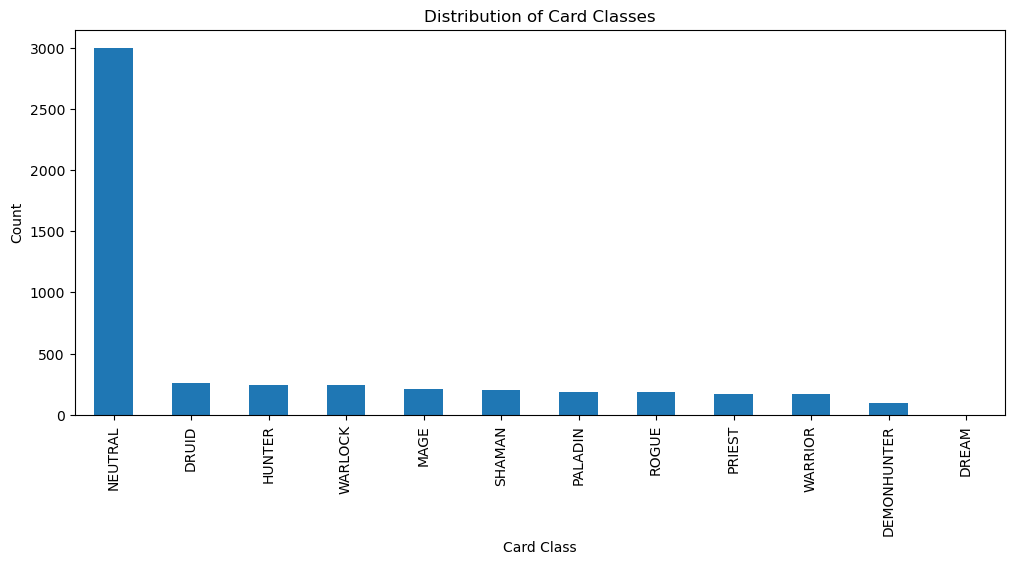

In [15]:
# Plot distribution of card classes
fig = plt.figure(figsize=(12, 5))
df['cardClass'].value_counts().plot(kind='bar')
plt.title('Distribution of Card Classes')
plt.xlabel('Card Class')
plt.ylabel('Count')
plt.show()

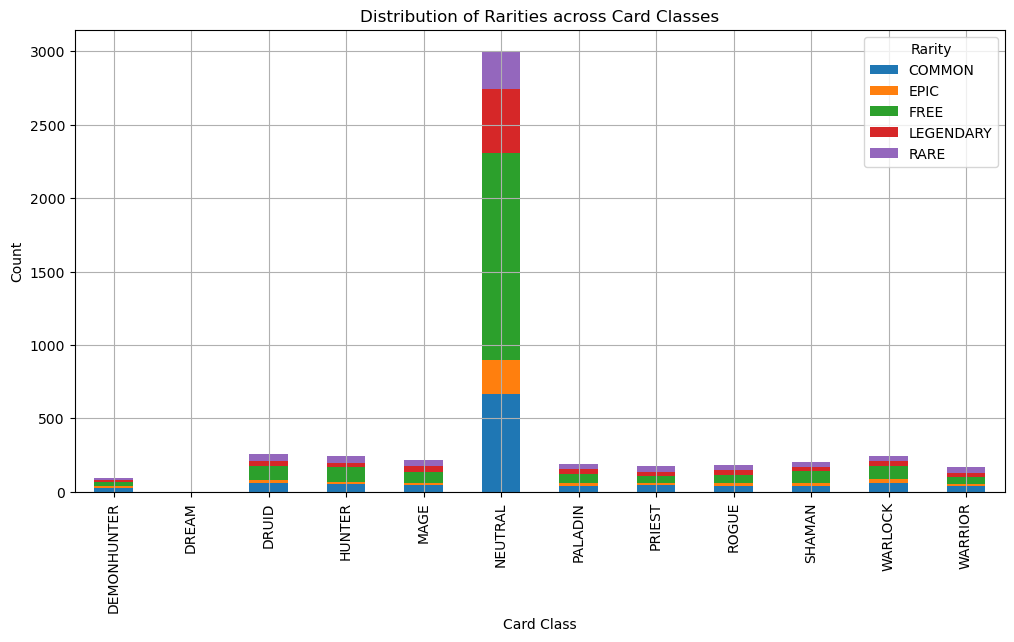

In [16]:
grouped_counts = df.groupby(['cardClass', 'rarity']).size().unstack(fill_value=0)

grouped_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.xlabel('Card Class')
plt.ylabel('Count')
plt.title('Distribution of Rarities across Card Classes')

plt.legend(title='Rarity')
plt.grid(True)
plt.show()

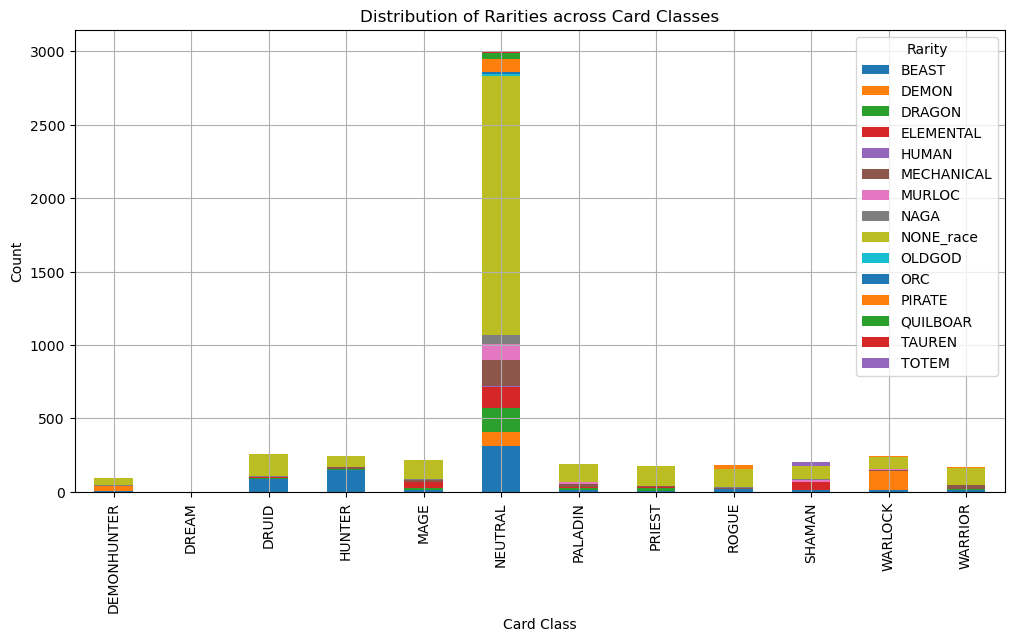

In [17]:
grouped_counts = df.groupby(['cardClass', 'race']).size().unstack(fill_value=0)

grouped_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.xlabel('Card Class')
plt.ylabel('Count')
plt.title('Distribution of Rarities across Card Classes')

plt.legend(title='Rarity')
plt.grid(True)
plt.show()

In [ ]:
df.head()

In [ ]:
df['text'][1]

In [18]:
def get_textual(column, value):
    return column + ": " + str(value)

In [19]:
def get_collectible_text(value):
    if pd.isna(value):
        return "collectible: no"
    return "collectible: yes"

In [20]:
def preprocess_sentence(sentence):
    sentence = re.sub(r'<[^>]+>', '', sentence)
    sentence = re.sub(r'[^\w\s]', '', sentence)
    sentence = sentence.replace('\n', ' ')
    sentence = sentence.lower()
    sentence = ' '.join(sentence.split())
    return sentence

In [21]:
df['health_text'] = df.apply(lambda x: get_textual('health', x['health']), axis=1)
df['attack_text'] = df.apply(lambda x: get_textual('attack', x['attack']), axis=1)
df['cost_text'] = df.apply(lambda x: get_textual('cost', x['cost']), axis=1)
df['collectible_text'] = df['collectible'].apply(get_collectible_text)
df['text'] = df['text'].fillna('')
df['text'] = df['text'].apply(preprocess_sentence)

In [22]:
df['combined_text'] = df['health_text'] + ' ' + df['set'].str.lower() + ' ' + df['attack_text'] + ' ' + df['cost_text'] + ' ' + df['rarity'].str.lower() + ' ' + df['rarity'].str.lower() + ' ' + df['collectible_text'] + ' ' + df['text'] + ' ' + df['race'].str.lower()

In [23]:
df.head()

,cardClass,health,id,name,set,attack,cost,rarity,artist,collectible,text,mechanics,race,Image Path,health_text,attack_text,cost_text,collectible_text,combined_text
0,ROGUE,13,Story_06_Tethys,Fleet Admiral Tethys,DARKMOON_FAIRE,1,4,FREE,NaN,NaN,at the end of your turn deal 1 damage to all e...,['TRIGGER_VISUAL'],NONE_race,train_images/Story_06_Tethys.jpg,health: 13,attack: 1,cost: 4,collectible: no,health: 13 darkmoon_faire attack: 1 cost: 4 fr...
1,NEUTRAL,5,EX1_016,Sylvanas Windrunner,EXPERT1,5,6,LEGENDARY,Glenn Rane,1.0,deathrattle take control of a random enemy minion,['DEATHRATTLE'],NONE_race,train_images/EX1_016.jpg,health: 5,attack: 5,cost: 6,collectible: yes,health: 5 expert1 attack: 5 cost: 6 legendary ...
2,NEUTRAL,15,Story_10_IcecrownObelisk,Icecrown Obelisk,STORMWIND,0,3,FREE,NaN,NaN,deathrattle gain control of this minion,['DEATHRATTLE'],NONE_race,train_images/Story_10_IcecrownObelisk.jpg,health: 15,attack: 0,cost: 3,collectible: no,health: 15 stormwind attack: 0 cost: 3 free fr...
3,DRUID,5,CORE_CS3_012,Nordrassil Druid,PLACEHOLDER_202204,3,4,RARE,Dave Greco,1.0,battlecry the next spell you cast this turn co...,['BATTLECRY'],NONE_race,train_images/CORE_CS3_012.jpg,health: 5,attack: 3,cost: 4,collectible: yes,health: 5 placeholder_202204 attack: 3 cost: 4...
4,MAGE,7,BOM_09_Dawngrasp_008t,Dawngrasp,ALTERAC_VALLEY,1,1,FREE,NaN,NaN,freeze any character damaged by this minion re...,['FREEZE'],NONE_race,train_images/BOM_09_Dawngrasp_008t.jpg,health: 7,attack: 1,cost: 1,collectible: no,health: 7 alterac_valley attack: 1 cost: 1 fre...


In [24]:
image_list = df['Image Path']
image_paths = []

In [25]:
labels = df['cardClass']

In [26]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
one_hot_labels = np.zeros((len(labels), 13))
one_hot_labels[np.arange(len(labels)), labels] = 1 

In [27]:
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
class_mapping

{'DEMONHUNTER': 0,
 'DREAM': 1,
 'DRUID': 2,
 'HUNTER': 3,
 'MAGE': 4,
 'NEUTRAL': 5,
 'PALADIN': 6,
 'PRIEST': 7,
 'ROGUE': 8,
 'SHAMAN': 9,
 'WARLOCK': 10,
 'WARRIOR': 11,
 nan: 12}

In [ ]:
img_test = None
for image in image_list:
    print(img)
    image_test = IMAGE_PATH + image
    break
    #print(IMAGE_PATH + image)
    #plt.imshow(img)
    #print(np.asarray(img))

In [ ]:
inp = df['combined_text'][0]
inp = clip.tokenize(inp).to(device)
image_test = preprocess(Image.open(image_test)).unsqueeze(0).to(device)

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_test)
    text_features = model.encode_text(inp)

In [ ]:
X = torch.cat((image_features, text_features), 1)

In [ ]:
X.shape

In [ ]:
image_features.shape, text_features.shape

In [ ]:
def combine_image_text(texts, images, labels, clip_model, clip_preprocess):
    image_text = []
    label_list = []
    for idx in range(len(df)):
        text = texts[idx]
        image = IMAGE_PATH + images[idx]
        print(text)
        text = clip.tokenize(text).to(device)
        image = preprocess(Image.open(image)).unsqueeze(0).to(device)

        with torch.no_grad():
            text_features = model.encode_text(text)
            image_features = model.encode_image(image)
        combined_features = torch.cat((text_features), image_features), 1))
        image_text.append(combined_features)
    return image_text

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

In [31]:
def combine_image_text(texts, images, labels, clip_model, clip_preprocess):
    def segment_text_func(text, max_segment_length=100):
        # Split text into segments of maximum length
        segments = []
        for i in range(0, len(text), max_segment_length):
            segment = text[i:i + max_segment_length]
            segments.append(segment)
        return segments
    
    image_text = []
    for idx in range(len(texts)):
        text = texts[idx]
        image = images[idx]
        
        # Process text in segments
        segments = segment_text_func(text)
        
        # Encode each segment separately
        segment_features = []
        for segment in segments:
            segment_text = clip.tokenize(segment).to(device)
            with torch.no_grad():
                segment_features.append(clip_model.encode_text(segment_text))
        
        # Aggregate segment representations
        aggregated_text_features = aggregate_features(segment_features)
        
        # Preprocess image
        image = clip_preprocess(Image.open(image)).unsqueeze(0).to(device)
        
        # Encode image
        with torch.no_grad():
            image_features = clip_model.encode_image(image)
        
        # Combine text and image features
        combined_features = torch.cat((aggregated_text_features, image_features), 1)
        image_text.append(combined_features)
    return image_text

def aggregate_features(features):
    # Aggregate segment features (e.g., by averaging)
    return torch.mean(torch.stack(features), dim=0)

In [32]:
texts = list(df['combined_text'])
images = [IMAGE_PATH + img for img in list(df['Image Path'])]
data = combine_image_text(texts, images, labels, model, preprocess)

In [78]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return feature, label

In [89]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc_1 = nn.Linear(input_size, hidden_size)
        self.fc_2 = nn.Linear(hidden_size, hidden_size)
        self.fc_3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        out = self.relu(self.fc_1(x))
        out = self.relu(self.fc_2(out))
        out = self.fc_3(out)
        return out

In [94]:
input_size = data[0].size(1)
hidden_size = 512
num_classes = len(label_encoder.classes_)
num_epochs = 10
lr = 0.001
batch_size = 16

lin_model = Model(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(lin_model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

In [95]:
train_dataset = CustomDataset(data, one_hot_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [96]:
def train():
    for epoch in range(num_epochs):
        total_loss = 0.0
        lin_model.train()
        for feature, label in train_loader:
            feature = feature.to(device)
            label = label.to(device)
            output = lin_model(feature)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch: {epoch+1}/{num_epochs} - Loss: {total_loss / len(train_loader)}")

In [97]:
train()

C:\Users\Felix\AppData\Local\Temp\ipykernel_12340\2872902945.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[idx], dtype=torch.float32)


Epoch: 1/10 - Loss: 0.17491153369729334
Epoch: 2/10 - Loss: 0.13947189205805577
Epoch: 3/10 - Loss: 0.12235132802123501
Epoch: 4/10 - Loss: 0.10755625962329333
Epoch: 5/10 - Loss: 0.0935587514930311
Epoch: 6/10 - Loss: 0.08124737499403001
Epoch: 7/10 - Loss: 0.06724044967845039
Epoch: 8/10 - Loss: 0.054629127431616804
Epoch: 9/10 - Loss: 0.03982408826112659
Epoch: 10/10 - Loss: 0.03107057160631748
